[INFO] filtering variables ...
[INFO] creating woe binning ...
[INFO] converting into woe values ...


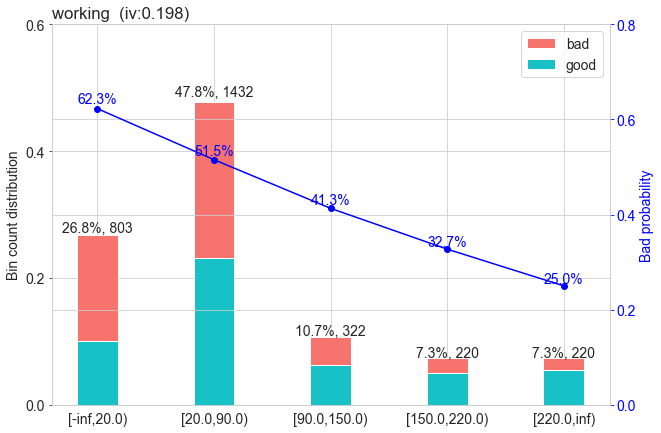

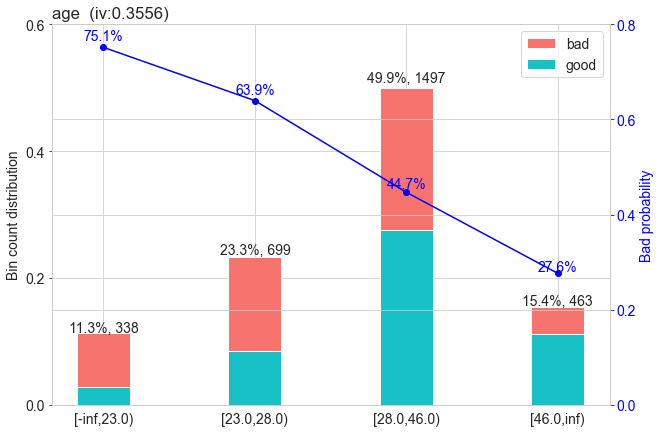

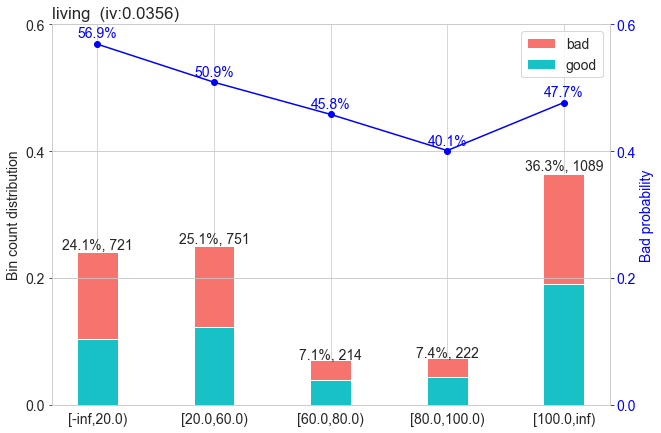

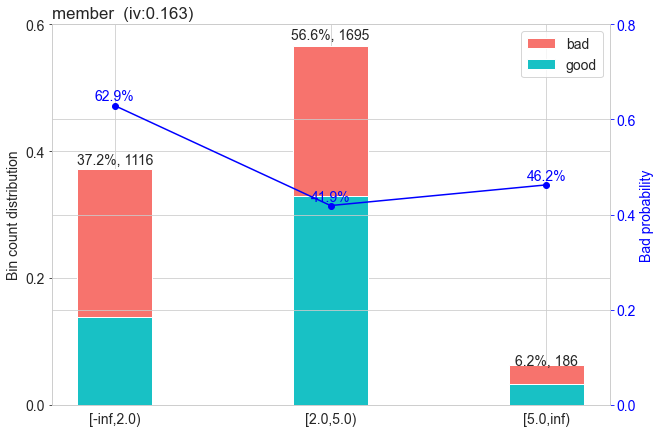

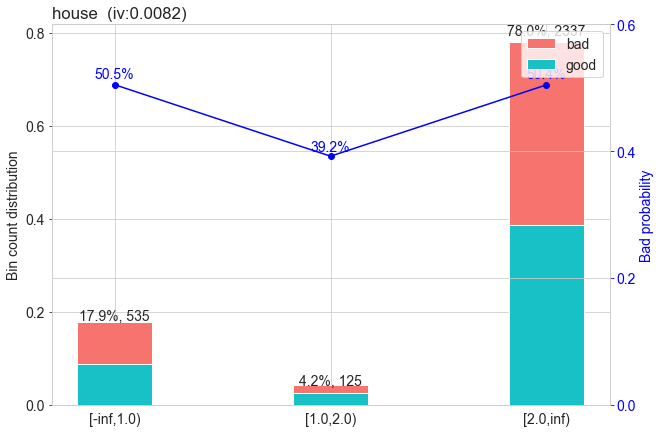

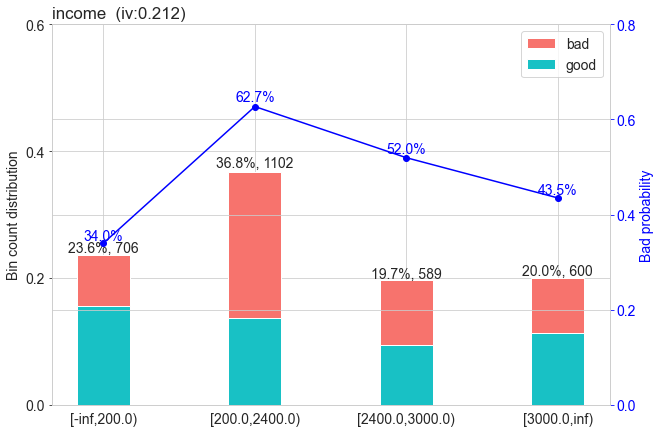

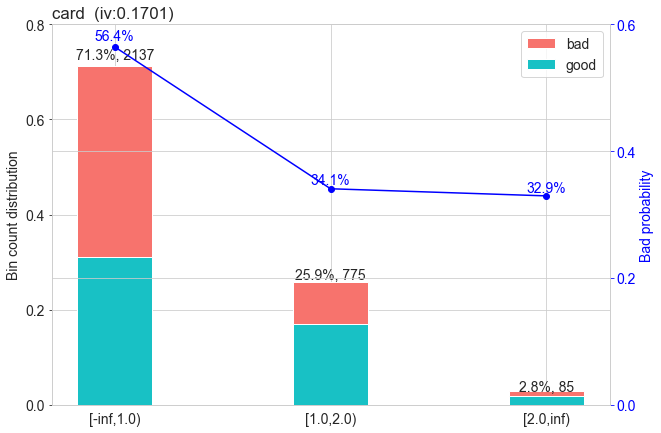

In [1]:
# Import Necessary Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scorecardpy as sc
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from scipy import interp
import warnings

# Configurations
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 7]  # Set consistent figure size for all plots
plt.rcParams['font.size'] = 14  # Set consistent font size for all plots
sns.set_style('whitegrid')  # Set consistent style for all plots

# Load Data
client_info = pd.read_excel('your_path_file.xlsx')

# Filter Variables and Bin Visualization
dt_s = sc.var_filter(client_info, y="default")
bins = sc.woebin(client_info, y='default', method='tree', breaks_list={'card': [0, 1, 2], 'house': [1, 2]})
sc.woebin_plot(bins)

# Transform variables using WOE
client_info_woe = sc.woebin_ply(client_info, bins)
y = client_info_woe['default']
X = client_info_woe.drop(columns=['default', 'house_woe'])



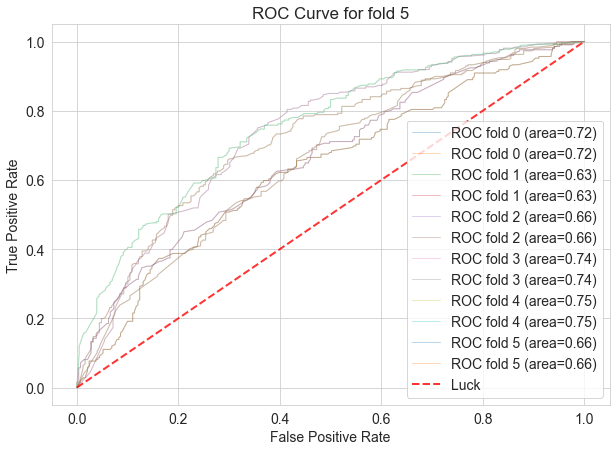

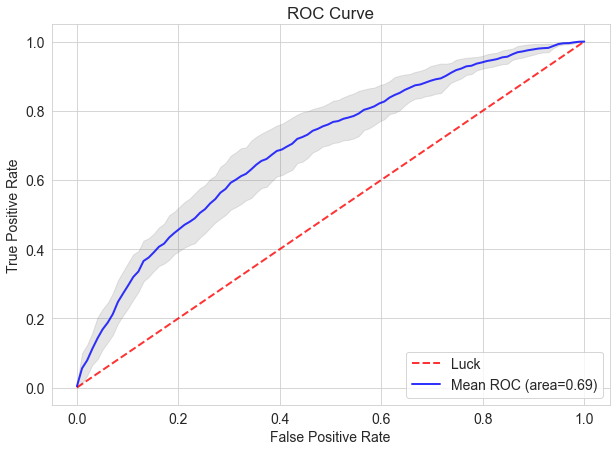

In [2]:
# Logistic Regression with KFold Cross Validation and ROC Curve Plot
kf = KFold(n_splits=6)
auc_best = 0
tprs, aucs = [], []
mean_fpr = np.linspace(0, 1, 100)

plt.figure(figsize=(10, 7))
for i, (train_index, test_index) in enumerate(kf.split(X)):
    # Prepare Train and Test sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit Logistic Regression Model
    lr = LogisticRegression(penalty='l1', C=0.9, solver='saga', n_jobs=-1)
    lr.fit(X_train, y_train)
    
    # Calculate AUC and Plot ROC for each fold
    y_pred = lr.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    tprs.append(interp(mean_fpr, fpr, tpr))
    aucs.append(auc_score)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f'ROC fold {i} (area={auc_score:.2f})')
    
    # Save the best model and associated data
    if auc_score > auc_best:
        auc_best = auc_score
        best_lr, best_X_train, best_X_test, best_y_train, best_y_test = lr, X_train, X_test, y_train, y_test

 # Each ROC Curve in a Separate Plot
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f'ROC fold {i} (area={auc_score:.2f})')


plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for fold {i}')
plt.legend(loc='lower right')
plt.show()
    
    
# Final ROC Curve Plotting
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (area={mean_auc:.2f})', lw=2, alpha=.8)
plt.fill_between(mean_fpr, np.maximum(np.mean(tprs, axis=0) - np.std(tprs, axis=0), 0), 
                 np.minimum(np.mean(tprs, axis=0) + np.std(tprs, axis=0), 1), color='gray', alpha=.2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

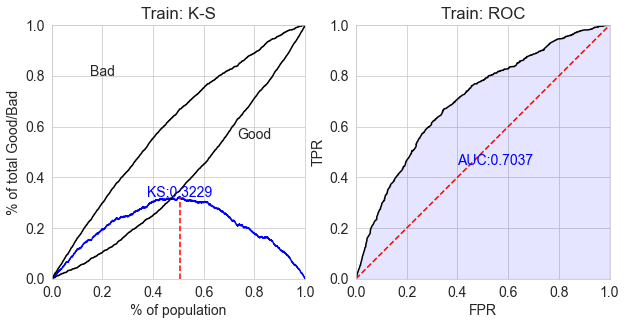

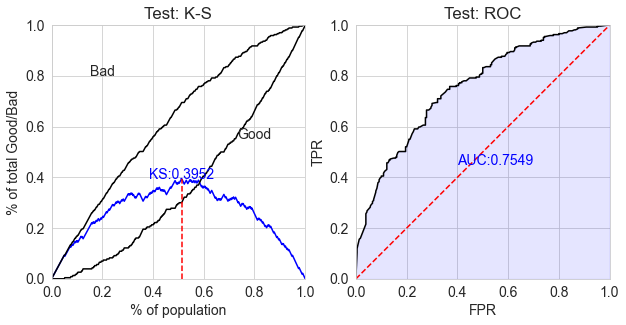

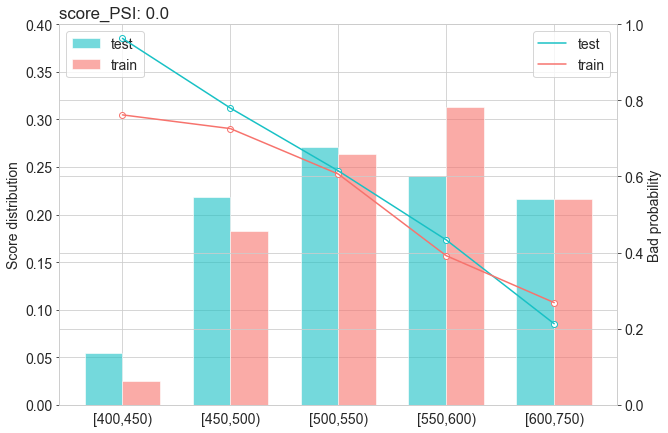

FileNotFoundError: [Errno 2] No such file or directory: '/path/to/save/excel/file.xlsx'

In [4]:
# Further Testing and Performance Evaluation
best_lr.fit(best_X_train, best_y_train)
train_perf = sc.perf_eva(best_y_train, best_lr.predict_proba(best_X_train)[:, 1], title="Train")
test_perf = sc.perf_eva(best_y_test, best_lr.predict_proba(best_X_test)[:, 1], title="Test")

# Scorecard Conversion, PSI Calculation, and Excel Export
card = sc.scorecard(bins, best_lr, best_X_train.columns, odds0=1/2)
score = sc.scorecard_ply(client_info, card, print_step=0)
sc.perf_psi(score={'train': score, 'test': score}, label={'train': best_y_train, 'test': best_y_test})
score.to_excel('/path/to/save/excel/file.xlsx', index=False)